In [92]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split


### Download Data & Basic Setup

In [13]:
# Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/global-weather-repository")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\17813\.cache\kagglehub\datasets\nelgiriyewithana\global-weather-repository\versions\536


In [26]:
data_path = r"C:\Users\17813\.cache\kagglehub\datasets\nelgiriyewithana\global-weather-repository\versions\536"
print(os.listdir(data_path))  # List all files in the directory
file_path = r"C:\Users\17813\.cache\kagglehub\datasets\nelgiriyewithana\global-weather-repository\versions\536\GlobalWeatherRepository.csv"
df = pd.read_csv(file_path)

['GlobalWeatherRepository.csv', 'state.db']


### Data Cleaning & Preprocessing
1. Handle missing values, outliers, and normalize data.


In [27]:
# display basic data information and column names
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60218 entries, 0 to 60217
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       60218 non-null  object 
 1   location_name                 60218 non-null  object 
 2   latitude                      60218 non-null  float64
 3   longitude                     60218 non-null  float64
 4   timezone                      60218 non-null  object 
 5   last_updated_epoch            60218 non-null  int64  
 6   last_updated                  60218 non-null  object 
 7   temperature_celsius           60218 non-null  float64
 8   temperature_fahrenheit        60218 non-null  float64
 9   condition_text                60218 non-null  object 
 10  wind_mph                      60218 non-null  float64
 11  wind_kph                      60218 non-null  float64
 12  wind_degree                   60218 non-null  int64  
 13  w

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [28]:
# check missing values per column 
df.isnull().sum()
# check missing values for each row
df[df.isnull().any(axis=1)]

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination


### From the above results, there is no missing values per column or per row. So we do not need to handle missing values. 

In [42]:
# remove duplicates inplace
df.drop_duplicates(inplace=True)
# change the last_updated column to human_readable date time formate
df['last_updated'] = pd.to_datetime(df['last_updated_epoch'], unit='s')
df.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 08:45:00,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 08:45:00,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 08:45:00,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 08:45:00,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 08:45:00,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


### Isolation Forest to detect outliers

#### Since this dataset contains 41 features, indicating that it is multivariate relationship, we cannot use normal IQR method to detect outliers. And Isolation Forest can be suitable.  

c:\Users\17813\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


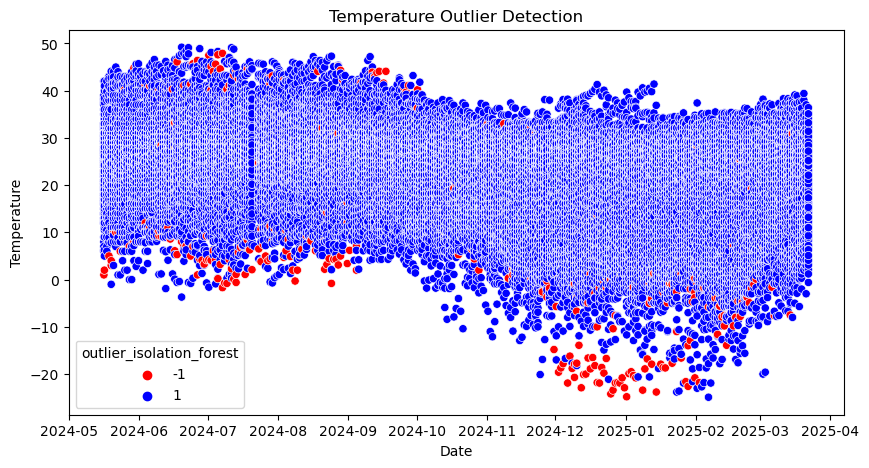

         country   location_name  latitude  longitude            timezone  \
35         Chile        Santiago  -33.4500   -70.6700    America/Santiago   
176        Tonga      Nuku`Aloia  -21.1300  -175.2000   Pacific/Tongatapu   
230        Chile        Santiago  -33.4500   -70.6700    America/Santiago   
273    Indonesia         Jakarta   -6.2100   106.8500        Asia/Jakarta   
468    Indonesia         Jakarta   -6.2100   106.8500        Asia/Jakarta   
...          ...             ...       ...        ...                 ...   
58495     Canada          Ottawa   45.4167   -75.7000     America/Toronto   
58821      Sudan            Juba   12.1500    24.4500     Africa/Khartoum   
59594  Singapore       Singapore    1.2931   103.8558      Asia/Singapore   
59709    Iceland  Vestmannaeyjar   63.3650   -20.2075  Atlantic/Reykjavik   
59907       Iran          Tehran   35.7261    51.3304         Asia/Tehran   

       last_updated_epoch        last_updated  temperature_celsius  \
35   

In [57]:
# Isolation Forest:

#only use numeric features:
numeric_features = df.select_dtypes(include=['number']).columns.tolist()
features = [col for col in numeric_features if col != 'temperature']  # Exclude 'temperature' from features
X = df[['temperature_celsius'] + features] 

# Create and fit Isolation Forest
iso_forest = IsolationForest(contamination=0.01)  
outliers = iso_forest.fit_predict(X)

# Mark the outliers (-1 indicates outliers, 1 indicates inliers)
df['outlier_isolation_forest'] = outliers

# Visualize outliers
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='last_updated', y='temperature_celsius', hue='outlier_isolation_forest', palette={1:'blue', -1:'red'})
plt.title('Temperature Outlier Detection')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

# Print the rows identified as outliers
outliers_df = df[df['outlier_isolation_forest'] == -1]
print(outliers_df)

In [99]:
cleaned_df = df[df['outlier_isolation_forest'] != -1]
cleaned_df.drop(columns = 'outlier_isolation_forest', inplace=True)
print(f'data shape before cleaning outliers: {df.shape}')
print(f'data shape after cleaning outliers: {cleaned_df.shape}')

data shape before cleaning outliers: (60218, 42)
data shape after cleaning outliers: (59615, 41)


C:\Users\17813\AppData\Local\Temp\ipykernel_16072\2754756356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop(columns = 'outlier_isolation_forest', inplace=True)


### Exploratory Data Analysis (EDA)
1. Perform basic EDA to uncover the trends, correlations, and patterns.
2. Generate visualizations for temperature and precipitation.


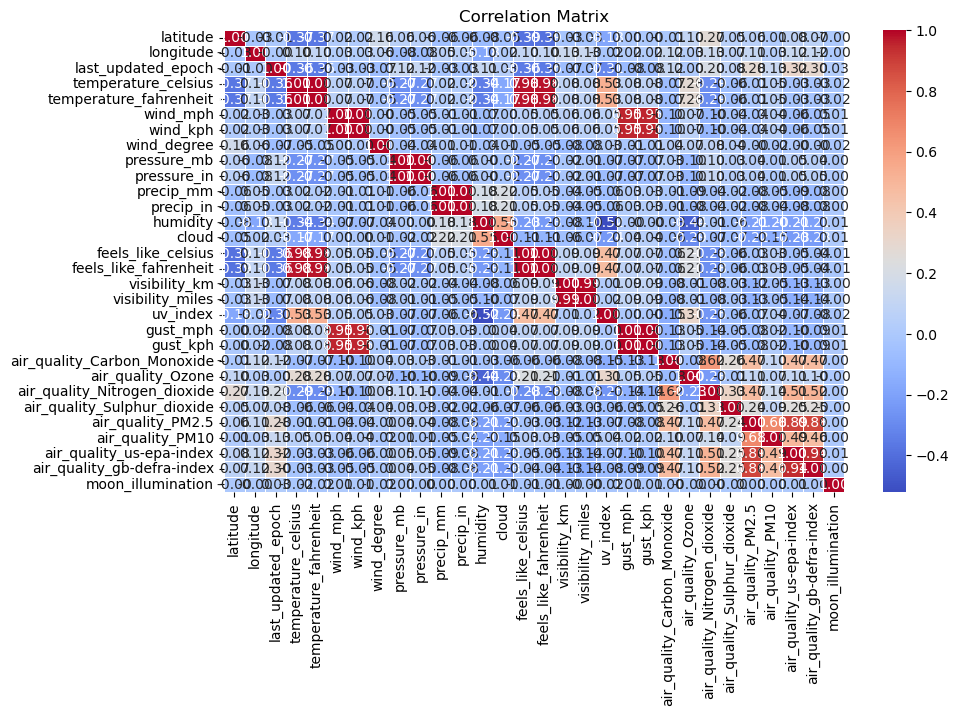

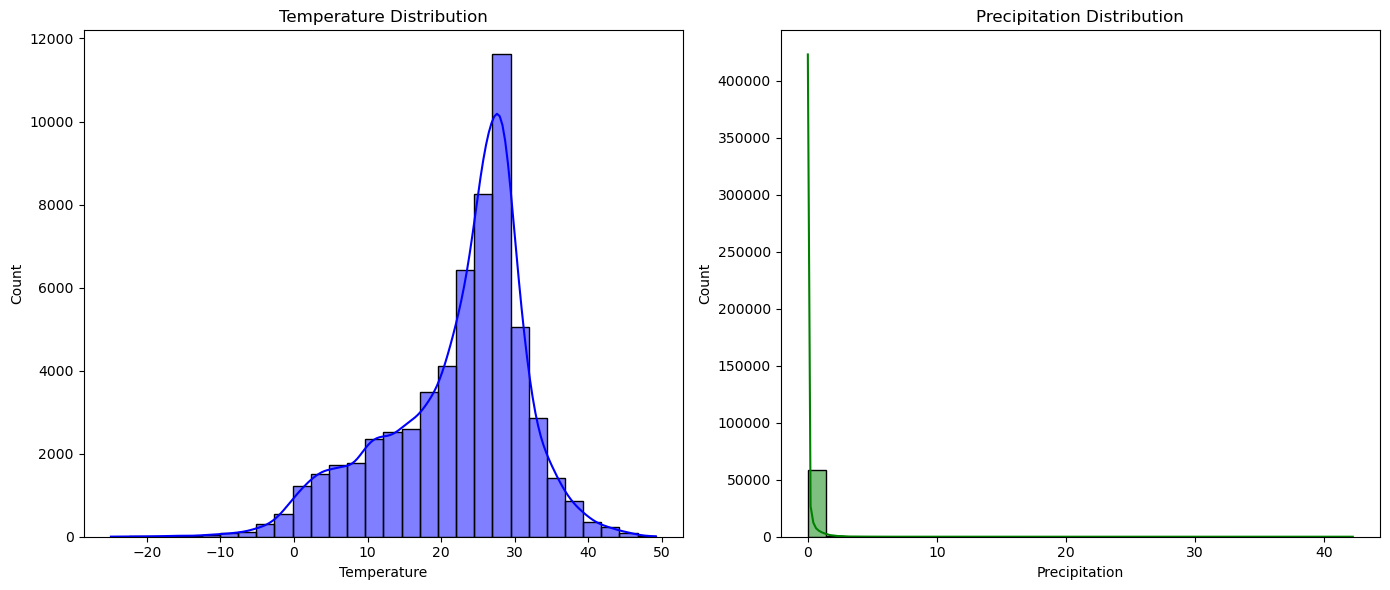

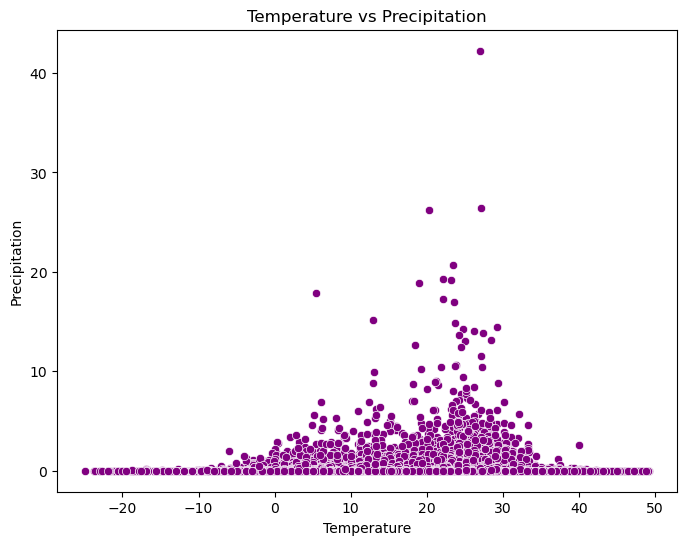

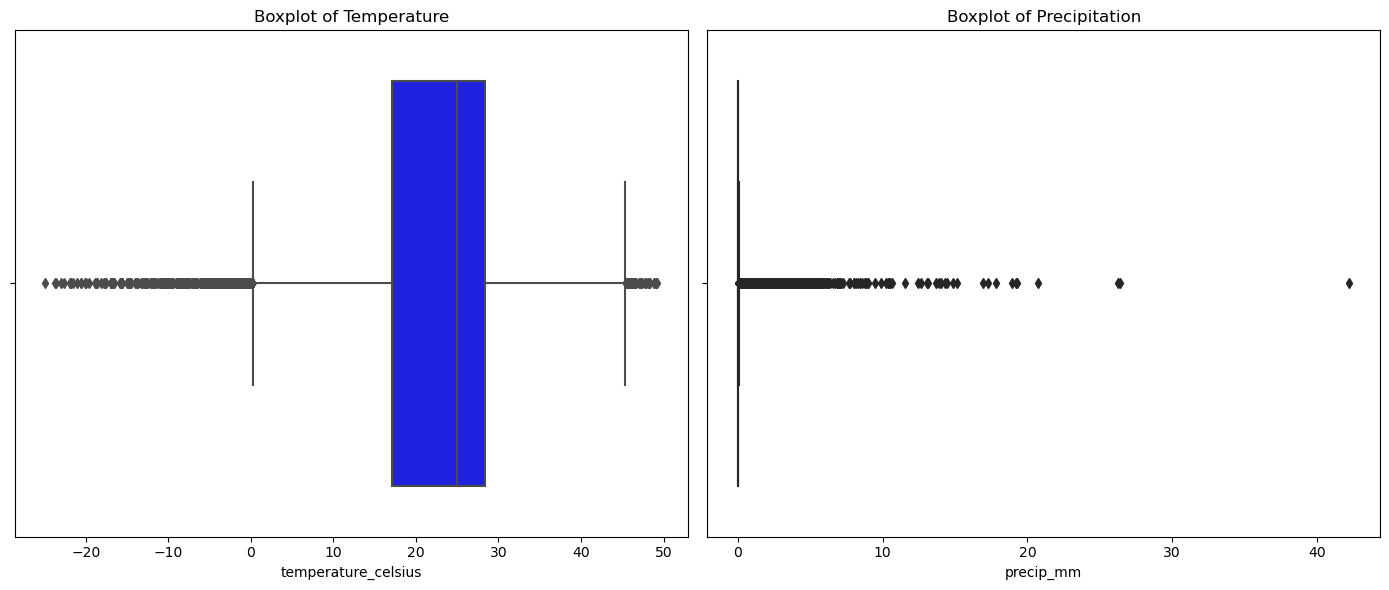

C:\Users\17813\AppData\Local\Temp\ipykernel_16072\3679398885.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['last_updated'] = pd.to_datetime(cleaned_df['last_updated'])  # Ensure 'date' column is in datetime format


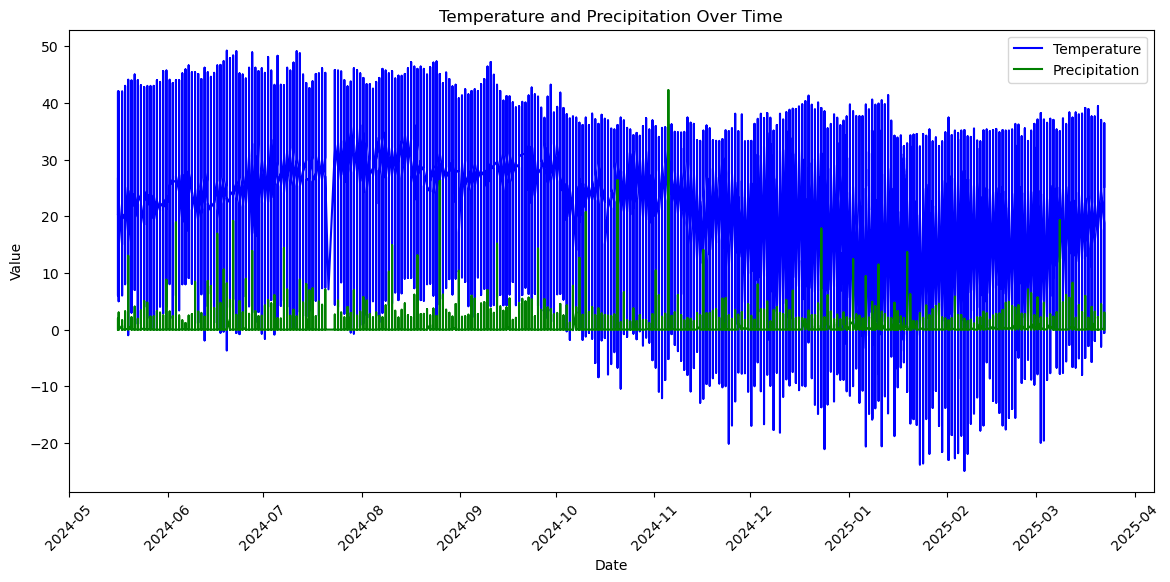

In [100]:
# correlation matrix heatmap:
correlation_matrix = cleaned_df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Distribution of Temperature and Precipitation
plt.figure(figsize=(14, 6))

# Temperature Distribution
plt.subplot(1, 2, 1)
sns.histplot(cleaned_df['temperature_celsius'], kde=True, color='blue', bins=30)
plt.title('Temperature Distribution')
plt.xlabel('Temperature')

# Precipitation Distribution
plt.subplot(1, 2, 2)
sns.histplot(cleaned_df['precip_mm'], kde=True, color='green', bins=30)
plt.title('Precipitation Distribution')
plt.xlabel('Precipitation')

plt.tight_layout()
plt.show()

# Scatter Plot: Temperature vs Precipitation
plt.figure(figsize=(8, 6))
sns.scatterplot(x='temperature_celsius', y='precip_mm', data=cleaned_df, color='purple')
plt.title('Temperature vs Precipitation')
plt.xlabel('Temperature')
plt.ylabel('Precipitation')
plt.show()

# 6. Boxplot to check for outliers (Temperature and Precipitation)
plt.figure(figsize=(14, 6))

# Boxplot for Temperature
plt.subplot(1, 2, 1)
sns.boxplot(x=cleaned_df['temperature_celsius'], color='blue')
plt.title('Boxplot of Temperature')

# Boxplot for Precipitation
plt.subplot(1, 2, 2)
sns.boxplot(x=cleaned_df['precip_mm'], color='green')
plt.title('Boxplot of Precipitation')

plt.tight_layout()
plt.show()

# Time Series Plot (if data has a time component, e.g., 'date')
if 'last_updated' in cleaned_df.columns:
    cleaned_df['last_updated'] = pd.to_datetime(cleaned_df['last_updated'])  # Ensure 'date' column is in datetime format
    plt.figure(figsize=(14, 6))
    plt.plot(cleaned_df['last_updated'], cleaned_df['temperature_celsius'], label='Temperature', color='blue')
    plt.plot(cleaned_df['last_updated'], cleaned_df['precip_mm'], label='Precipitation', color='green')
    plt.title('Temperature and Precipitation Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

### Model Building
1. Build a basic forecasting model and evaluate its performance using different metrics.
2. Use lastupdated feature for the time series analysis

c:\Users\17813\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\17813\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\17813\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\17813\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean Absolute Error (MAE): 9.18309907004633
Root Mean Squared Error (RMSE): 10.61929171885531
Mean Absolute Percentage Error (MAPE): 259.17083313295115


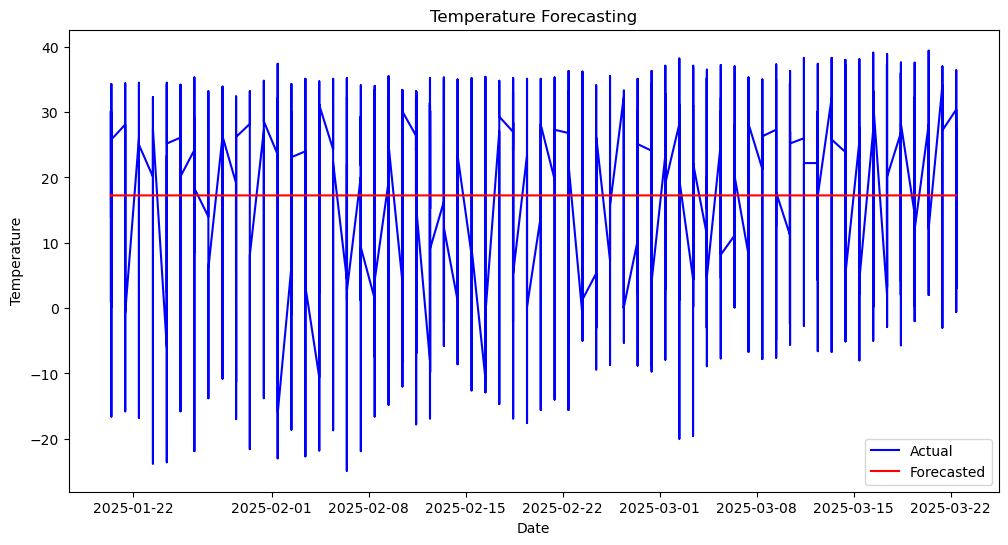

In [101]:
cleaned_df = cleaned_df.sort_values(by='last_updated')  # Sort by datetime
cleaned_df.set_index('last_updated', inplace=True)

# Extract time-related features
cleaned_df['month'] = cleaned_df.index.month
cleaned_df['day_of_week'] = cleaned_df.index.dayofweek  # 0 = Monday, 6 = Sunday
cleaned_df['hour'] = cleaned_df.index.hour

# predict 'temperature_celsius' as the target variable for forecasting
target = 'temperature_celsius'

# Split the data into training and testing sets 
train_size = int(len(cleaned_df) * 0.8)
train, test = cleaned_df.iloc[:train_size], cleaned_df.iloc[train_size:]

# Build and fit the ARIMA model
model = ARIMA(train[target], order=(1, 1, 1))
model_fit = model.fit()

# Make forecasts on the test set
forecast = model_fit.forecast(steps=len(test))

# Evaluate the model's performance
# Calculate the evaluation metrics
mae = mean_absolute_error(test[target], forecast)
rmse = np.sqrt(mean_squared_error(test[target], forecast))
test_reset = test[target].reset_index(drop=True)
forecast_reset = pd.Series(forecast).reset_index(drop=True)
# Calculate MAPE
non_zero_values = test_reset != 0  # Create a mask to filter out zeros in the actual values
mape = np.mean(np.abs((test_reset[non_zero_values] - forecast_reset[non_zero_values]) / test_reset[non_zero_values])) * 100

# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# 7. Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test[target], label='Actual', color='blue')
plt.plot(test.index, forecast, label='Forecasted', color='red')
plt.title('Temperature Forecasting')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

c:\Users\17813\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


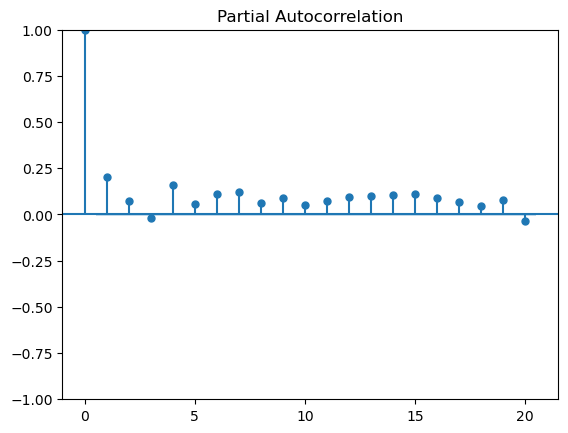

In [94]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

plot_pacf(cleaned_df['temperature_celsius'].dropna(), lags=20)
plt.show()
